# Prerequisites

## Import libraries

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Colab Notebooks/PhD/data/random_sequences_small.txt', 'r') as rf:
  print(rf.read())

## Create pandas dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD/data/random_sequences_tiny.txt', sep=";", names=['first_file', 'second_file', 'third_file', 'fourth_file', 'fifth_file'])
df = df.reset_index()
df = df.drop(columns=['fifth_file']) 
df = df.rename(columns = {'index': 'first_file', 'first_file':'second_file', 'second_file':'third_file', 'third_file':'fourth_file', 'fourth_file':'fifth_file'}, inplace = False)

# Replace categorical with numerical values
df = df.replace(['IPS'], 1, regex=True)
df = df.replace(['Laboratory Results'], 2, regex=True)
df = df.replace(['Prescription'], 3, regex=True)
df = df.replace(['Image Report'], 4, regex=True) 
df = df.replace(['Allergies'], 5, regex=True)
df = df.replace(['Diagnostic Report'], 6, regex=True)
df = df.replace(['Pathology History'], 7, regex=True)
df = df.replace(['Vital Signs'], 8, regex=True)
df = df.replace(['Medication Report'], 9, regex=True)

df.head

<bound method NDFrame.head of     first_file  second_file  third_file  fourth_file  fifth_file
0            3            3           1            2           5
1            5            5           1            2           2
2            3            1           3            1           1
3            3            5           2            1           1
4            3            7           5            1           2
5            3            2           3            3           4
6            2            3           3            5           1
7            2            3           2            1           1
8            2            2           5            6           2
9            5            3           1            2           7
10           1            1           1            1           2
11           5            5           1            2           3
12           1            1           1            3           4
13           3            2           1            9        

Histogram

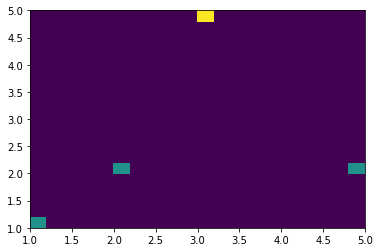

In [ ]:
plt.hist2d(df.iloc[0], df.iloc[1], 20)
plt.show()

# LSTM model

## Series to supervised

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  if isinstance(data, list):
    n_vars = 1
  else:
    n_vars = data.shape[1]
  if isinstance(data, pd.DataFrame):
    pass
  else:
    data = pd.DataFrame(data)
  cols, names = list(), list()
  print(n_vars)
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    print(i)
    cols.append(data.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(data.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  #cols_to_use = names[:len(names) - (n_out)]
  #agg = agg[cols_to_use]
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg


new_df = series_to_supervised(df,n_in= 1, n_out=1)

5
1


In [ ]:
new_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,3.0,3.0,1.0,2.0,5.0,5,5,1,2,2
2,5.0,5.0,1.0,2.0,2.0,3,1,3,1,1
3,3.0,1.0,3.0,1.0,1.0,3,5,2,1,1
4,3.0,5.0,2.0,1.0,1.0,3,7,5,1,2
5,3.0,7.0,5.0,1.0,2.0,3,2,3,3,4


## Min - Max scaler

In [ ]:
def Min_max_scal(data):
	array = data.values
	values_ = array.astype('float32')
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled = scaler.fit_transform(values_)
	return scaled

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns = new_df.columns
scaled_np = Min_max_scal(new_df)
scaled_df = pd.DataFrame(scaled_np, columns=[columns])

scaled_df

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
0,-0.2,-0.333333,-1.00,-0.75,0.333333,0.6,0.333333,-1.00,-0.75,-0.666667
1,0.6,0.333333,-1.00,-0.75,-0.666667,-0.2,-1.000000,-0.50,-1.00,-1.000000
2,-0.2,-1.000000,-0.50,-1.00,-1.000000,-0.2,0.333333,-0.75,-1.00,-1.000000
3,-0.2,0.333333,-0.75,-1.00,-1.000000,-0.2,1.000000,0.00,-1.00,-0.666667
4,-0.2,1.000000,0.00,-1.00,-0.666667,-0.2,-0.666667,-0.50,-0.50,0.000000
5,-0.2,-0.666667,-0.50,-0.50,0.000000,-0.6,-0.333333,-0.50,0.00,-1.000000
6,-0.6,-0.333333,-0.50,0.00,-1.000000,-0.6,-0.333333,-0.75,-1.00,-1.000000
7,-0.6,-0.333333,-0.75,-1.00,-1.000000,-0.6,-0.666667,0.00,0.25,-0.666667
8,-0.6,-0.666667,0.00,0.25,-0.666667,0.6,-0.333333,-1.00,-0.75,1.000000
9,0.6,-0.333333,-1.00,-0.75,1.000000,-1.0,-1.000000,-1.00,-1.00,-0.666667


Train - Test data 

In [ ]:
def reshape_data_single_lag(reframed, train_percentage, test_percentage, valid_percentage):
	# split into train and test sets
	values = reframed.values
	# Sizes
	train_size = int(len(reframed) * train_percentage)
	test_size = int(len(reframed) * test_percentage)
	valid_size = int(len(reframed) * valid_percentage)

	train = values[:train_size]
	test = values[train_size:train_size + test_size]
	val = values[train_size + test_size:]

	# split into input and outputs
	train_X, train_y = train[:, :-1], train[:, -1]
	test_X, test_y = test[:, :-1], test[:, -1]
	val_X, val_y = val[:, :-1], val[:, -1]
	# print(train_X.shape)

	### this reshape below is we using it for univariate timeseries
	# reshape input to be 3D [samples, timesteps, features]
	train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
	test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
	val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

	print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

	return train_X, train_y, test_X, test_y, val_X, val_y

In [ ]:
train_X, train_y, test_X, test_y, val_X, val_y = reshape_data_single_lag(scaled_df,  0.45, 0.35, 0.2 )

(22, 1, 9) (22,) (17, 1, 9) (17,) (10, 1, 9) (10,)


## LSTM Model architecture

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, MaxPooling3D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, Conv3D

def LSTM_model(train_X, train_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(LSTM(90, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(70, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(50, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(30, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(30, return_sequences = True,  input_shape=(train_X.shape[1], train_X.shape[2])))  # 1 , 2
    model.add(Dropout(0.75))
    model.add(LSTM(15, return_sequences = False ))
    model.add(Dropout(0.5))
    #model.add(LSTM(30, return_sequences = False ))
    #model.add(Dropout(0.2))
    #model.add(LSTM(15, return_sequences = False ))
    #model.add(Dense(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X, train_y, epochs=10, batch_size=8, validation_data=(test_X, test_y),verbose=2, shuffle=False)
    return model

In [ ]:
model = LSTM_model(train_X, train_y, test_X, test_y)

Epoch 1/10
3/3 - 12s - loss: 0.5087 - val_loss: 0.5362
Epoch 2/10
3/3 - 0s - loss: 0.5032 - val_loss: 0.5303
Epoch 3/10
3/3 - 0s - loss: 0.4985 - val_loss: 0.5244
Epoch 4/10
3/3 - 0s - loss: 0.4908 - val_loss: 0.5184
Epoch 5/10
3/3 - 0s - loss: 0.4859 - val_loss: 0.5123
Epoch 6/10
3/3 - 0s - loss: 0.4810 - val_loss: 0.5063
Epoch 7/10
3/3 - 0s - loss: 0.4736 - val_loss: 0.5002
Epoch 8/10
3/3 - 0s - loss: 0.4700 - val_loss: 0.4941
Epoch 9/10
3/3 - 0s - loss: 0.4586 - val_loss: 0.4880
Epoch 10/10
3/3 - 0s - loss: 0.4591 - val_loss: 0.4818


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 90)             36000     
_________________________________________________________________
dropout (Dropout)            (None, 1, 90)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 70)             45080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 70)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             24200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 30)             9

## Train - Test  loses

In [ ]:
def plot_train_test_loss(model):
    mpl.rcParams['figure.figsize'] = (12, 8)
    mpl.rcParams['axes.grid'] = False
    # plot history
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

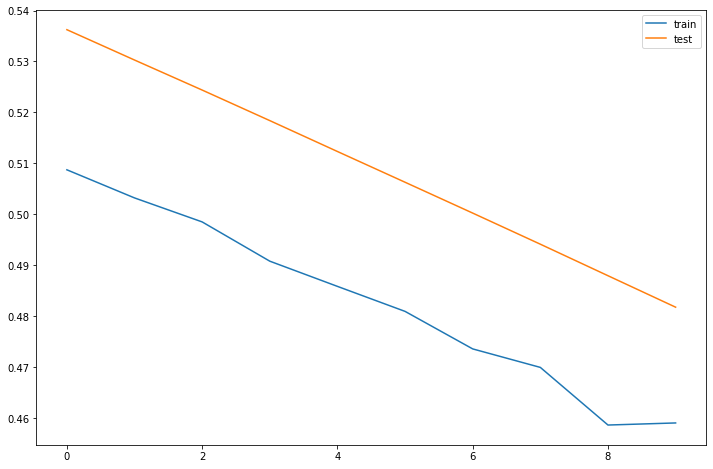

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

plot_train_test_loss(model)

## Predictions and scores

In [ ]:
def predictions_and_scores_for_LSTM(model, test_X,test_y):
	# make a prediction
	yhat = model.predict(test_X)
	# test_X_reshaped = test_X.reshape((test_X.shape[0], 3*2))
	yhat_reshaped = yhat.reshape((yhat.shape[0], yhat.shape[1]))

	test_y_reshaped = test_y.reshape((len(test_y), 1))

	# calculate RMSE and R2_score
	rmse = sqrt(mean_squared_error(test_y_reshaped, yhat_reshaped))
	r2score = r2_score(test_y_reshaped, yhat_reshaped)
	
	print('Test RMSE: %.3f' % rmse)
	print('R2_score: %f' % r2score)
	return rmse, r2score

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

predictions_and_scores_for_LSTM(model, test_X, test_y)

Test RMSE: 0.694
R2_score: -0.594278


(0.6941017582219153, -0.5942779327227838)

# Influential Instances using Deletion Diagnostics

In [ ]:
# The weights of the first model without deleting one or more 
initial_model_weights = model.get_weights()
len(initial_model_weights)


20

In [ ]:
model_weights = []
rmse = []
r2score = []

for index, i in enumerate(train_X):
  train_X_without_i = np.delete(train_X, index, 0)
  train_y_without_i = np.delete(train_y, index, 0)
  model_without_i = LSTM_model(train_X_without_i, train_y_without_i, test_X, test_y)
  rmse_without_i, r2score_without_i = predictions_and_scores_for_LSTM(model_without_i, train_X_without_i, train_y_without_i)
  model_weights += model_without_i.get_weights()
  rmse.append(rmse_without_i)
  r2score.append(r2score_without_i)




Epoch 4/10
3/3 - 0s - loss: 0.5108 - val_loss: 0.5199
Epoch 5/10
3/3 - 0s - loss: 0.5045 - val_loss: 0.5143
Epoch 6/10
3/3 - 0s - loss: 0.4999 - val_loss: 0.5086
Epoch 7/10
3/3 - 0s - loss: 0.4931 - val_loss: 0.5029
Epoch 8/10
3/3 - 0s - loss: 0.4855 - val_loss: 0.4971
Epoch 9/10
3/3 - 0s - loss: 0.4816 - val_loss: 0.4913
Epoch 10/10
3/3 - 0s - loss: 0.4782 - val_loss: 0.4855
Test RMSE: 0.686
R2_score: -0.733438
Epoch 1/10
3/3 - 12s - loss: 0.5124 - val_loss: 0.5363
Epoch 2/10
3/3 - 0s - loss: 0.5074 - val_loss: 0.5307
Epoch 3/10
3/3 - 0s - loss: 0.5020 - val_loss: 0.5252
Epoch 4/10
3/3 - 0s - loss: 0.4950 - val_loss: 0.5194
Epoch 5/10
3/3 - 0s - loss: 0.4905 - val_loss: 0.5136
Epoch 6/10
3/3 - 0s - loss: 0.4883 - val_loss: 0.5079
Epoch 7/10
3/3 - 0s - loss: 0.4775 - val_loss: 0.5021
Epoch 8/10
3/3 - 0s - loss: 0.4749 - val_loss: 0.4962
Epoch 9/10
3/3 - 0s - loss: 0.4709 - val_loss: 0.4904
Epoch 10/10
3/3 - 0s - loss: 0.4613 - val_loss: 0.4845
Test RMSE: 0.678
R2_score: -0.523404
Epoch

In [ ]:
len(model_without_i.get_weights())

20

In [ ]:
len(model_weights)

440

## Identification of most Influential instances with the use of DFBETA

$DFBETA = β - β^{(-i)}$

In [ ]:
initial_model_weights[0].shape

(9, 360)

In [ ]:
model_weights[20].shape

(9, 360)

In [ ]:
print(len(initial_model_weights))
print(len(model_weights))

20
440


In [ ]:
for index, i in enumerate(model_weights):
  # print(i)
  print(index)

## DFBETA

In [ ]:
total_weights = int(len(model_weights)/len(initial_model_weights))
count=0
# print(len(model_weights))
# print(len(initial_model_weights))

# for i in range(0, 2):
count = 0
dfbeta_all = []
dfbeta_sum = []
for i in range(0, len(model_weights)):
  dfbeta = np.subtract(initial_model_weights[i-count], model_weights[i])
  dfbeta_all.append(dfbeta)
  if (i % len(initial_model_weights)==0):
    count+=len(initial_model_weights)
    dfbeta_sum.append(np.sum(dfbeta))

dfbeta_sum_abs = np.abs(dfbeta_sum)
dfbeta_sum = np.array(dfbeta_sum)

In [ ]:
dfbeta_sum

In [ ]:
dfbeta_sum_abs

In [ ]:
most_influential_instances_indices = []
number_of_influential_instances = len(dfbeta_sum)
for i in range(0, number_of_influential_instances):
  most_influential_instances_indices.append(np.argmax(dfbeta_sum))
  dfbeta_sum[np.argmax(dfbeta_sum)] = -1000

most_influential_instances_indices

In [ ]:
dfbeta_sum_abs

In [ ]:
influential_instances = []
for i in range(0, len(most_influential_instances_indices)):
  influential_instances.append(df.loc[i].values.tolist())

influential_instances

[[3, 3, 1, 2, 5],
 [5, 5, 1, 2, 2],
 [3, 1, 3, 1, 1],
 [3, 5, 2, 1, 1],
 [3, 7, 5, 1, 2],
 [3, 2, 3, 3, 4],
 [2, 3, 3, 5, 1],
 [2, 3, 2, 1, 1],
 [2, 2, 5, 6, 2],
 [5, 3, 1, 2, 7],
 [1, 1, 1, 1, 2],
 [5, 5, 1, 2, 3],
 [1, 1, 1, 3, 4],
 [3, 2, 1, 9, 2],
 [6, 3, 7, 3, 2],
 [6, 2, 2, 2, 2],
 [4, 1, 1, 1, 2],
 [4, 2, 3, 5, 6],
 [1, 2, 1, 3, 1],
 [1, 1, 5, 4, 3],
 [4, 1, 3, 1, 5],
 [1, 1, 3, 2, 2]]

## Root Mean Square Error

In [ ]:
rmse_np = np.array(rmse)
least_rmse_indices = []
for i in range(0, len(rmse)):
  least_rmse_indices.append(np.argmin(rmse_np))
  rmse_np[np.argmin(rmse_np)] = 99999

least_rmse_indices

[8, 2, 5, 6, 1, 17, 16, 0, 13, 15, 14, 21, 20, 3, 9, 7, 12, 10, 19, 18, 4, 11]

#$R^2$

In [ ]:
r2score_np = np.array(r2score)
highest_r2score_indices = []
for i in range(0, len(r2score)):
  highest_r2score_indices.append(np.argmax(r2score_np))
  r2score_np[np.argmax(r2score_np)] = -100

highest_r2score_indices

[2, 5, 6, 1, 0, 13, 15, 14, 21, 20, 3, 9, 7, 17, 10, 12, 18, 4, 11, 19, 16, 8]

## DFBETA, RMSE, $R^2$

In [ ]:
metrics = np.column_stack([most_influential_instances_indices, least_rmse_indices, highest_r2score_indices])
metrics

array([[ 7,  8,  2],
       [ 8,  2,  5],
       [12,  5,  6],
       [20,  6,  1],
       [11,  1,  0],
       [16, 17, 13],
       [13, 16, 15],
       [ 4,  0, 14],
       [ 1, 13, 21],
       [21, 15, 20],
       [ 5, 14,  3],
       [ 2, 21,  9],
       [ 3, 20,  7],
       [10,  3, 17],
       [ 6,  9, 10],
       [15,  7, 12],
       [18, 12, 18],
       [ 9, 10,  4],
       [14, 19, 11],
       [ 0, 18, 19],
       [19,  4, 16],
       [17, 11,  8]])

# K-Means using Dynamic Time Warping

In [ ]:
!python -m pip install tslearn

     |████████████████████████████████| 793 kB 8.5 MB/s 


In [ ]:
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

kmeans_model = TimeSeriesKMeans(n_clusters=len(metrics), init="random")

kmeans_model.fit(influential_instances)

TimeSeriesKMeans(dtw_inertia=False, init='random', max_iter=50,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=22, n_init=1, n_jobs=None,
                 random_state=None, tol=1e-06, verbose=0)

TypeError: ignored

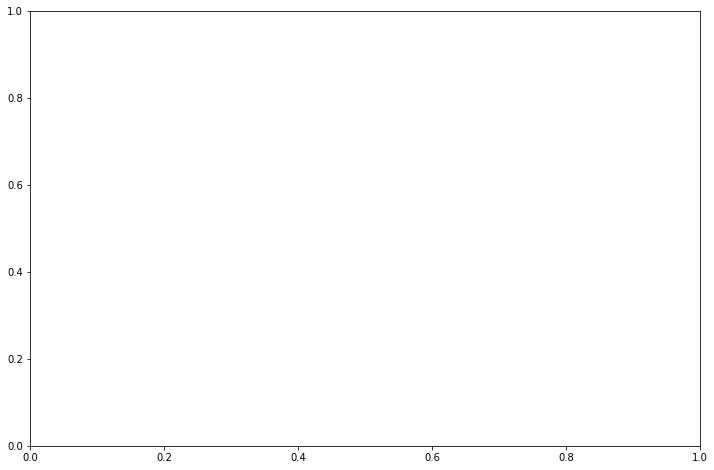

In [ ]:
plt.plot()
# plt.show()
# df.index

In [ ]:
res = kmeans_model.predict(df.loc[[49]].values.tolist())
kmeans_model.cluster_centers_

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


array([[[3.],
        [7.],
        [5.],
        [1.],
        [2.]],

       [[1.],
        [2.],
        [1.],
        [3.],
        [1.]],

       [[3.],
        [3.],
        [1.],
        [2.],
        [5.]],

       [[6.],
        [2.],
        [2.],
        [2.],
        [2.]],

       [[5.],
        [5.],
        [1.],
        [2.],
        [3.]],

       [[3.],
        [2.],
        [1.],
        [9.],
        [2.]],

       [[1.],
        [1.],
        [3.],
        [2.],
        [2.]],

       [[5.],
        [5.],
        [1.],
        [2.],
        [3.]],

       [[1.],
        [1.],
        [3.],
        [2.],
        [2.]],

       [[5.],
        [3.],
        [1.],
        [2.],
        [7.]],

       [[3.],
        [2.],
        [1.],
        [9.],
        [2.]],

       [[3.],
        [7.],
        [5.],
        [1.],
        [2.]],

       [[6.],
        [2.],
        [2.],
        [2.],
        [2.]],

       [[2.],
        [3.],
        [2.],
        [1.],
        

For each point (instance in the data set) we calcuate the Dynamic Time Warping for all cluster centers. If it less than a given distance it is considered a point in the cluster, otherwise it is considered an outlier and is dropped from the data set. The final data set is then used by the LSTM model for re-training. 

# Re-train LSTM model based on K-Means outcomes

# Appendix - 

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

from google.colab import files
src = list(files.upload().values())[0]
open('lstm.py','wb').write(src)
# open('preprocessing.py', 'wb').write(src)

from preprocessing import read_csv, series_to_supervised, Min_max_scal, reshape_data_single_lag
from lstm import LSTM_model

df = read_csv()
new_df = series_to_supervised(df, n_in=1, n_out=1)
new_df = new_df.astype(int)

columns = new_df.columns
scaled_np = Min_max_scal(new_df)
scaled_df = pd.DataFrame(scaled_np, columns=[columns])

train_X, train_y, test_X, test_y, val_X, val_y = reshape_data_single_lag(scaled_df,  0.45, 0.35, 0.2 )

model = LSTM_model(train_X, train_y, test_X, test_y)
model.summary()

KeyboardInterrupt: ignored